#### TODO:

Train&Test
- split the dataset into train and test

Inputs&Labels
- mix the labels and input orders
- Deal with the labels and inputes 

Articles&Tenses
- Remove the articles and present tense verbs

## Imports

In [48]:
import os
import requests
import pandas as pd
from PIL import Image
import io
import ast
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from lambeq.backend.grammar import Ty, Box 
from lambeq import BobcatParser, AtomicType, Sim14Ansatz, RemoveCupsRewriter


print("(*) All libraries are successfully imported!\n")

(*) All libraries are successfully imported!



## Dataset

Split the dataset and label into trainign and testing similar to the pennyland model

In [49]:
# ==============================================
# ==============================================

# Read the CSV file
file_path = os.path.join(os.getcwd(), "features_dataset.csv")
df = pd.read_csv(file_path)

# Extract the sentence
sentence = df['sentence']
image_1 = df['image_1']
image_2 = df['image_2']
label_image1 = df['label_image1']
label_image2 = df['label_image2']

df = pd.DataFrame({
    'sentence': sentence,
    'image_1': image_1,
    'image_2': image_2,
    'label_image1': label_image1,
    'label_image2': label_image2
})

# Make the image_1 and image_2 into float lists instead of strings
df["image_1"] = df["image_1"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df["image_2"] = df["image_2"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# # Split the dataset
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Output sizes of the splits
# print(f"Training set size: {len(train_df)}")
# print(f"Testing set size: {len(test_df)}")

print(" NOTE: Split train and test data")
print(" NOTE: Split inputs and labels")

print("(*) Data Extracted!\n")

 NOTE: Split train and test data
 NOTE: Split inputs and labels
(*) Data Extracted!



## Sentences Diagram & Circuit

 parsing sentences ..
 ↓ example senetnce diagram


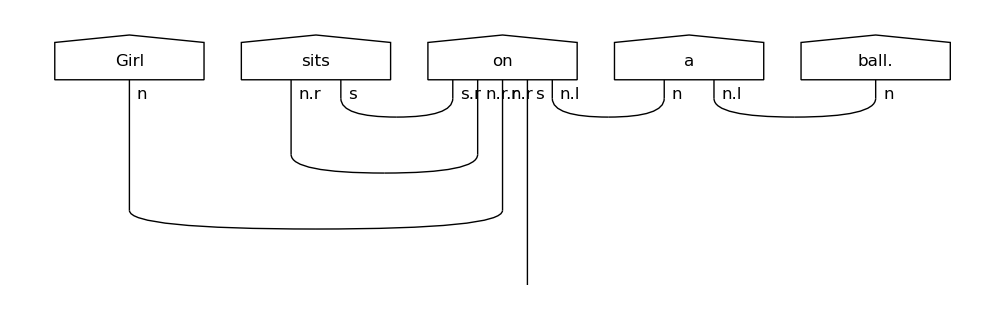

 creating diagrams ..
 ↓ sample sentence diagram without cups


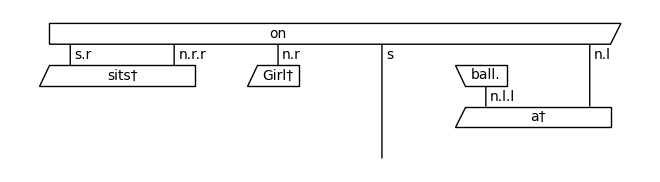

 ↓ sample sentence circuit


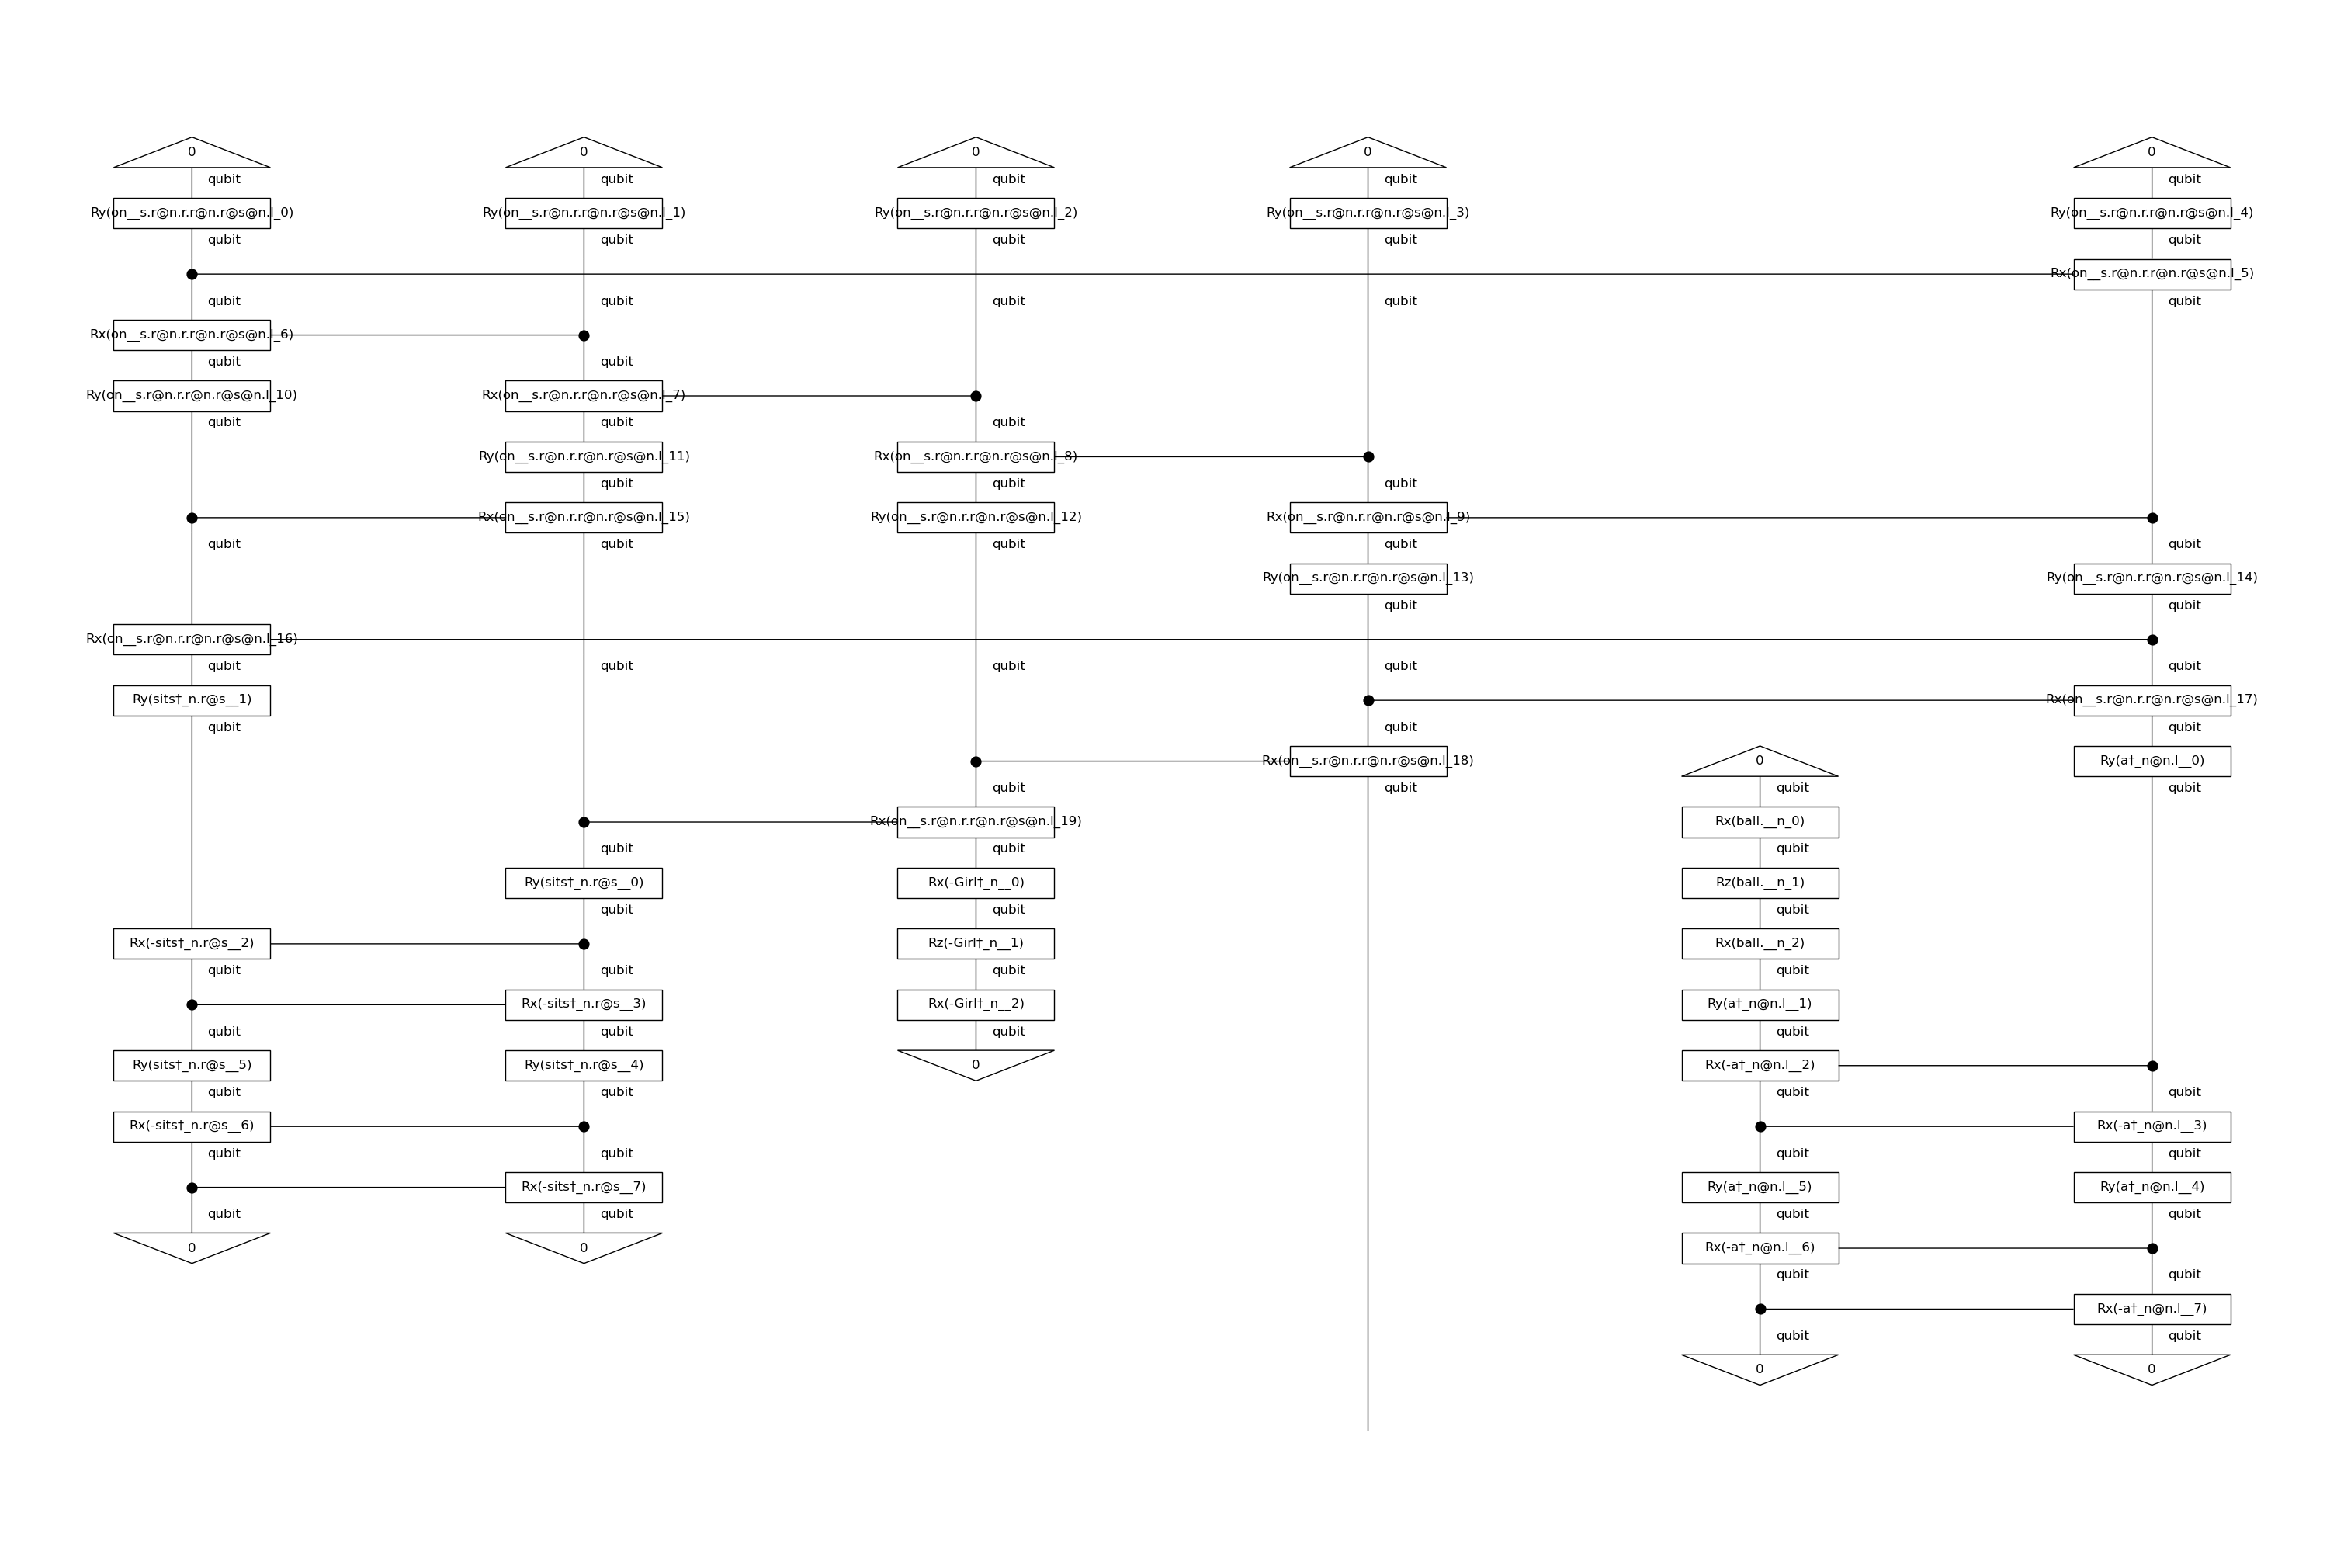

(*) Ansatz created for all senetnces!



In [50]:
# ==============================================
# CREATE SENTENCE DIAGRAMS
# ==============================================

remove_cups = RemoveCupsRewriter()

# Parse the sentence 
sentences = df["sentence"]

# Use BobbcatParser to convert it into a string diagram
print(" parsing sentences ..")
parser = BobcatParser(verbose='suppress')
raw_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in sentences]
print(" ↓ example senetnce diagram")
raw_sentence_diagrams[1].draw(figsize=(14, 3), fontsize=12)

# Use remoce cups to decrease the number of wires used
print(" creating diagrams ..")
train_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in raw_sentence_diagrams]
print(' ↓ sample sentence diagram without cups')
train_diagrams_sentence[1].draw()

ansatz_sentence = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1},n_layers=1)
train_circuits_sentence = [ansatz_sentence(diagram) for diagram in train_diagrams_sentence]
print(' ↓ sample sentence circuit')
train_circuits_sentence[1].draw(figsize=(30, 20), fontsize=12)

print("(*) Ansatz created for all senetnces!\n")

## Image Diagram & Circuit

circuit for positive image: complete


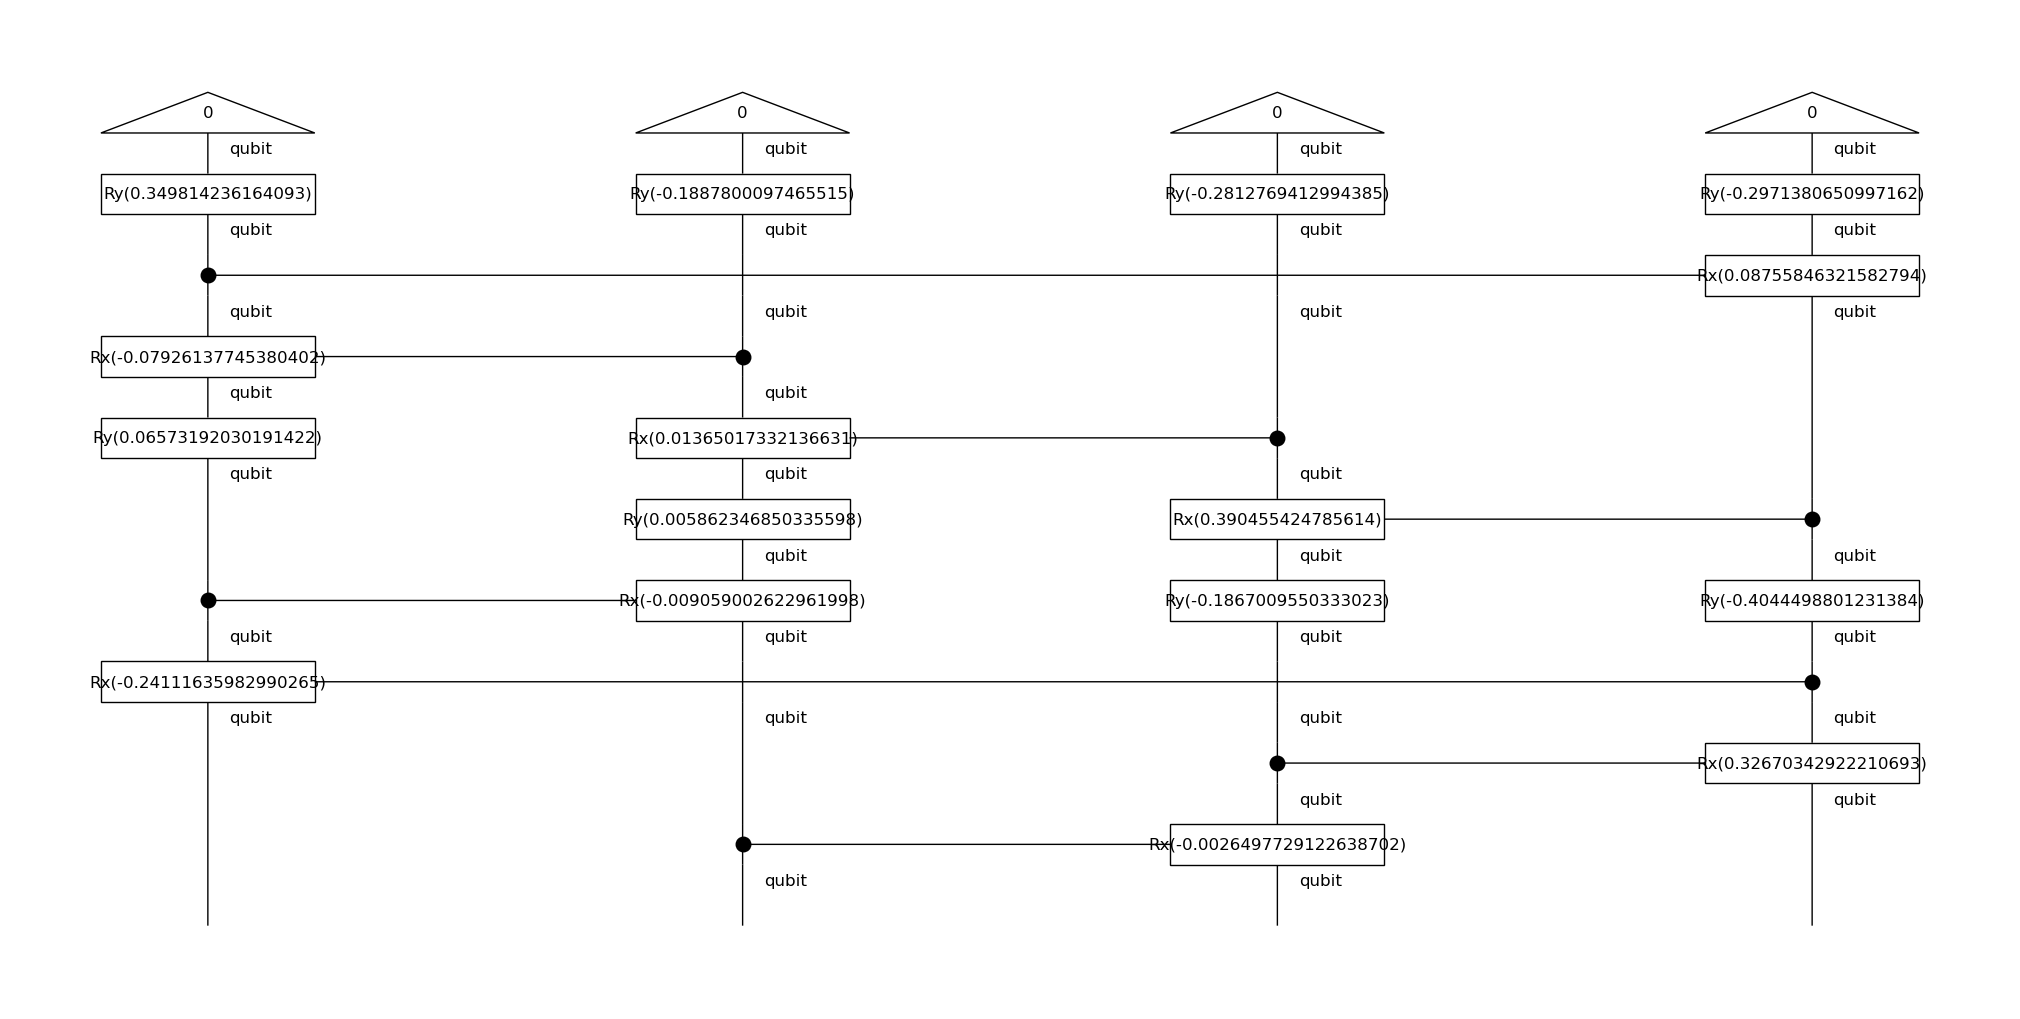

circuit for negative image: complete


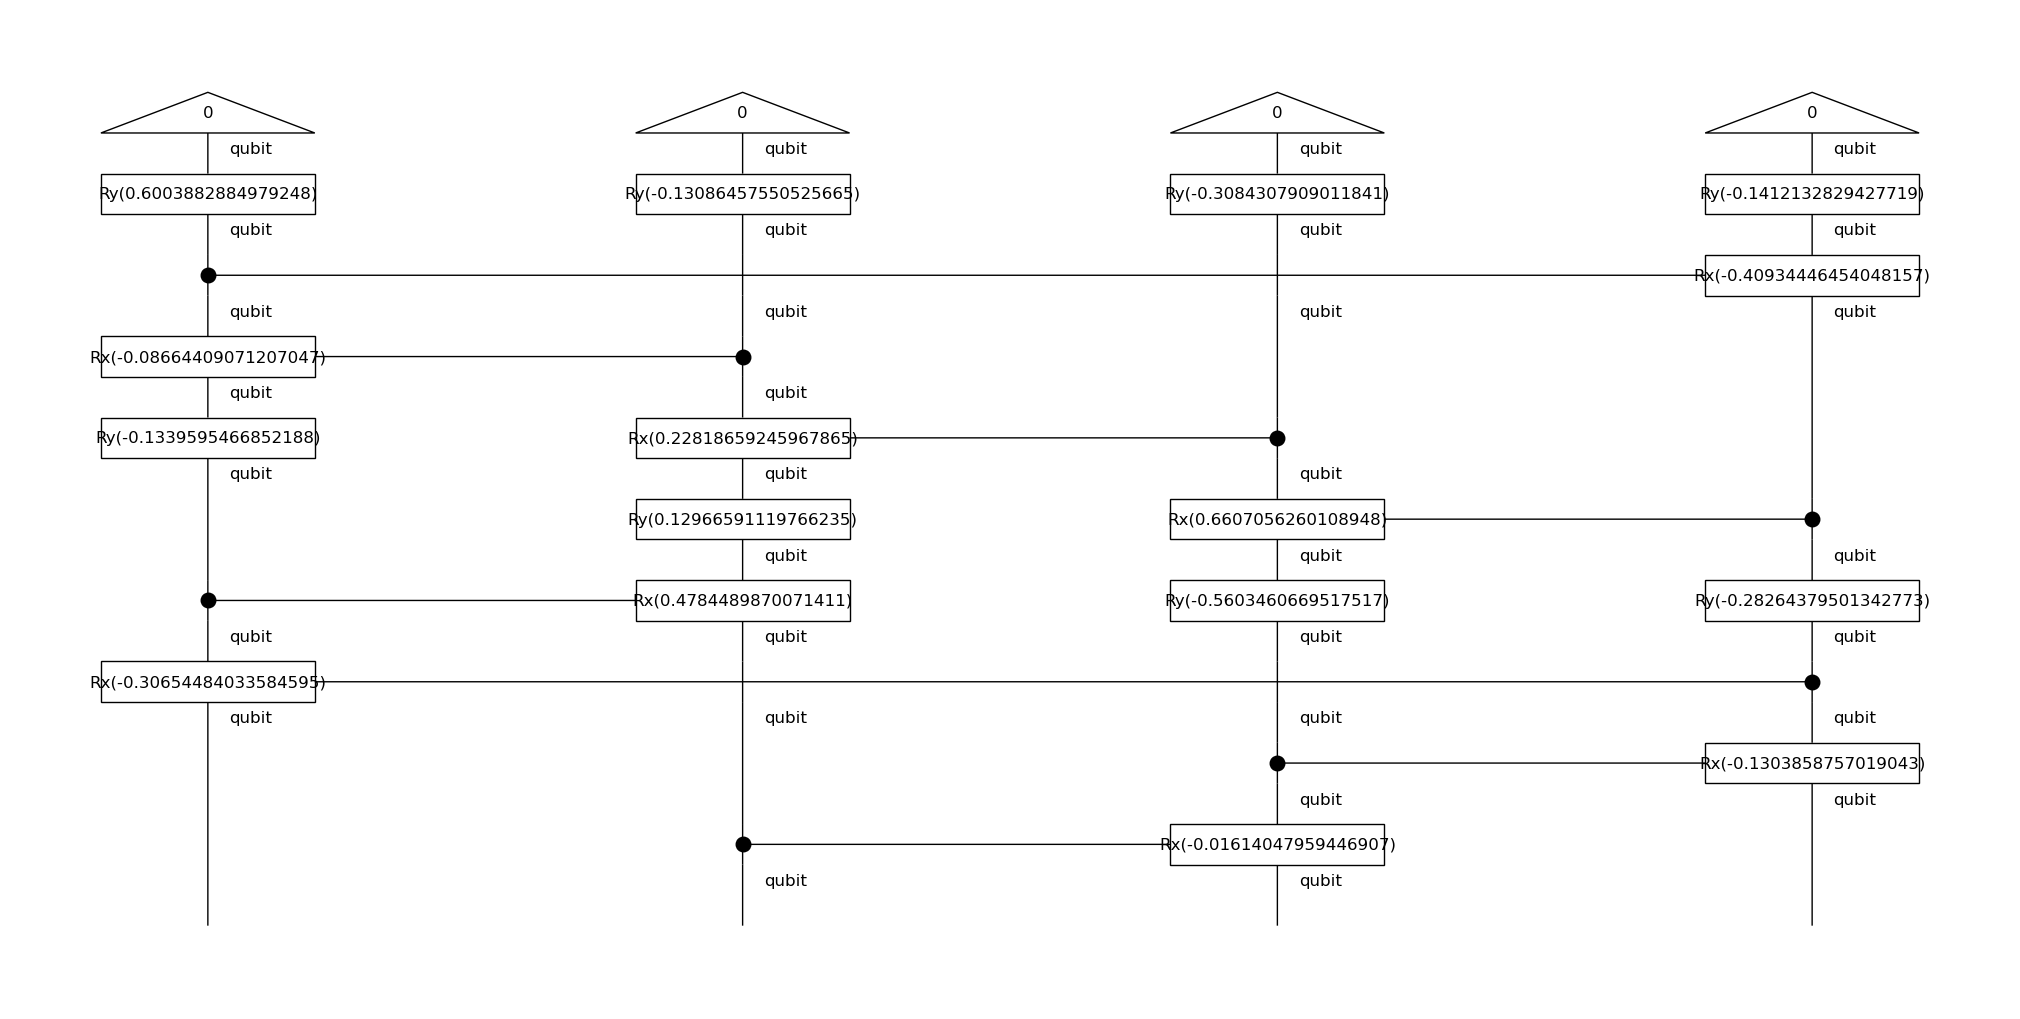

(*) Circuits and digrams created for all images!



In [51]:
# Create a new image Ty
image_type = Ty("image")
image_box = Box(name = "IMAGE", dom = Ty(), cod= image_type)
# image_box.draw(figsize=(14, 3), fontsize=12)

# Create template Ansatz
ansatz = Sim14Ansatz({image_type: 4}, n_layers=1)
image_circ = ansatz(image_box)
# print('↓ template image circuit')
# image_circ.draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit POSITIVE
images_1 = df["image_1"]
train_circuits_image1 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in images_1]
print("circuit for positive image: complete")
train_circuits_image1[1].draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit NEGATIVE
images_2 = df["image_2"]
train_circuits_image2 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in images_2]
print("circuit for negative image: complete")
train_circuits_image2[1].draw(figsize=(20, 10), fontsize=12)

print("(*) Circuits and digrams created for all images!\n")

## Combined for Sentence & Images:

#### Diagram template 

NOTE: diagrams that cause an error are not added to the list
 this is an error due to miscalculation from lambeq
Error at index 10: Diagram 0 (cod=n.r @ s @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 26: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 31: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 44: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 64: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 80: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 87: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at index 107: Diagram 0 (cod=n @ image @ image) does not compose with diagram 1 (dom=s @ image @ image)
Error at

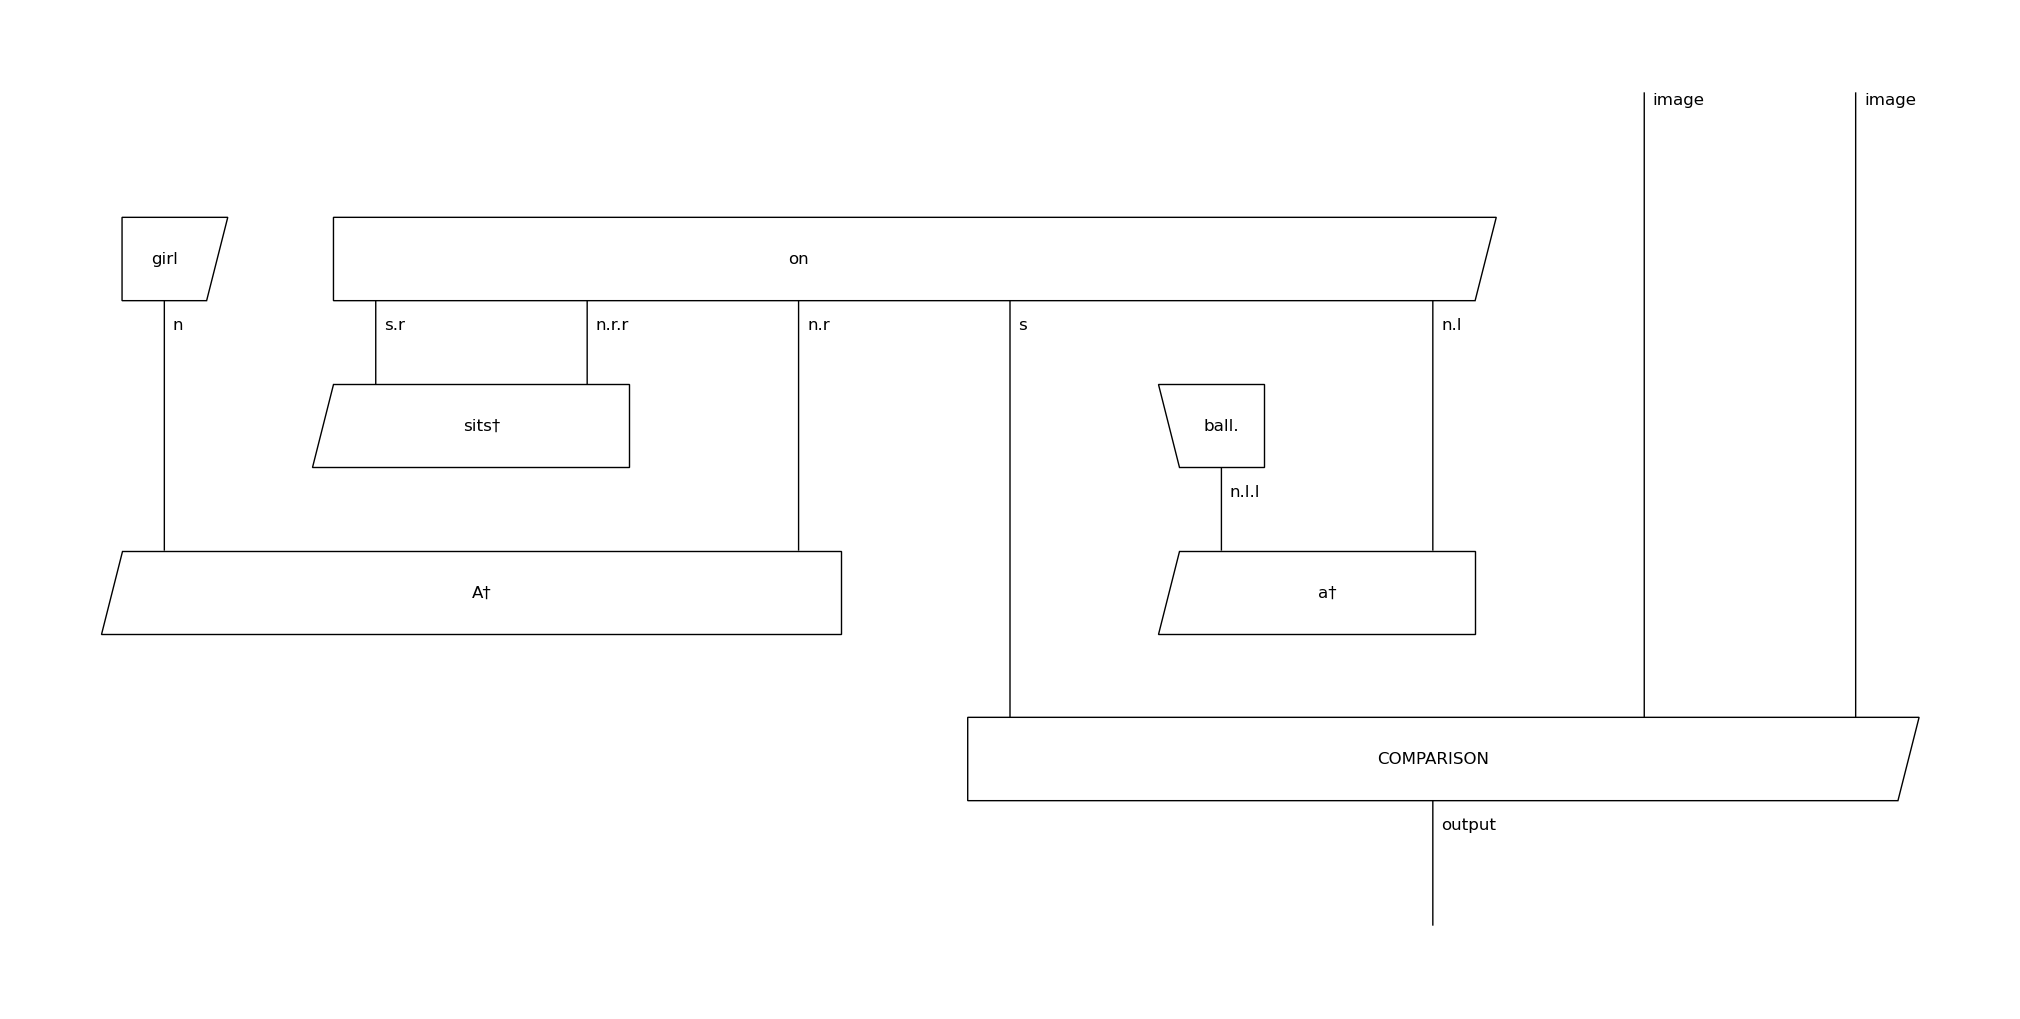

In [52]:
# CREATE FINAL CIRCUIT

# Create new Type
output_type = Ty("output")
comparison_box = Box("COMPARISON", AtomicType.SENTENCE @ image_type @ image_type, output_type)

# Draws diagram with comparison box (0,1) - Sentence digarm and comparison box is in grammar form
conc_diagrams = []
print("NOTE: diagrams that cause an error are not added to the list")
print(" this is an error due to miscalculation from lambeq")
print("=======================")
for num in range(len(df)):
    try:
        temp = train_diagrams_sentence[num] @ image_type @ image_type >> comparison_box
        conc_diagrams.append(temp)
    except Exception as e:
        print(f"Error at index {num}: {e}")
print("=======================")

print("")
print(f"\n(*) {len(conc_diagrams)} / {len(df)} diagrams completed successfully!\n")

# diagrams = [(sentence_diagram @ image_type @ image_type) >> comparison_box for sentence_diagram in train_diagrams_sentence]
print(' ↓ template merged diagram : (sentence, image1, image2)')
conc_diagrams[0].draw(figsize=(20, 10), fontsize=12)


#### Circuit Template

NOTE: ansatz that cause an error are not added to the list
 this is due to a prepositional phrase found in the sentence
Error at index 35: Ty(p)
Error at index 48: Ty(p)
Error at index 53: Ty(p)
Error at index 81: Ty(p)
Error at index 91: Ty(p)
Error at index 126: Ty(p)
Error at index 135: Ty(p)
Error at index 146: Ty(p)
Error at index 177: Ty(p)

(*) 175 / 184 / 204 diagrams completed successfully!

 ↓ template circuit : (sentence, image_type , image_type)


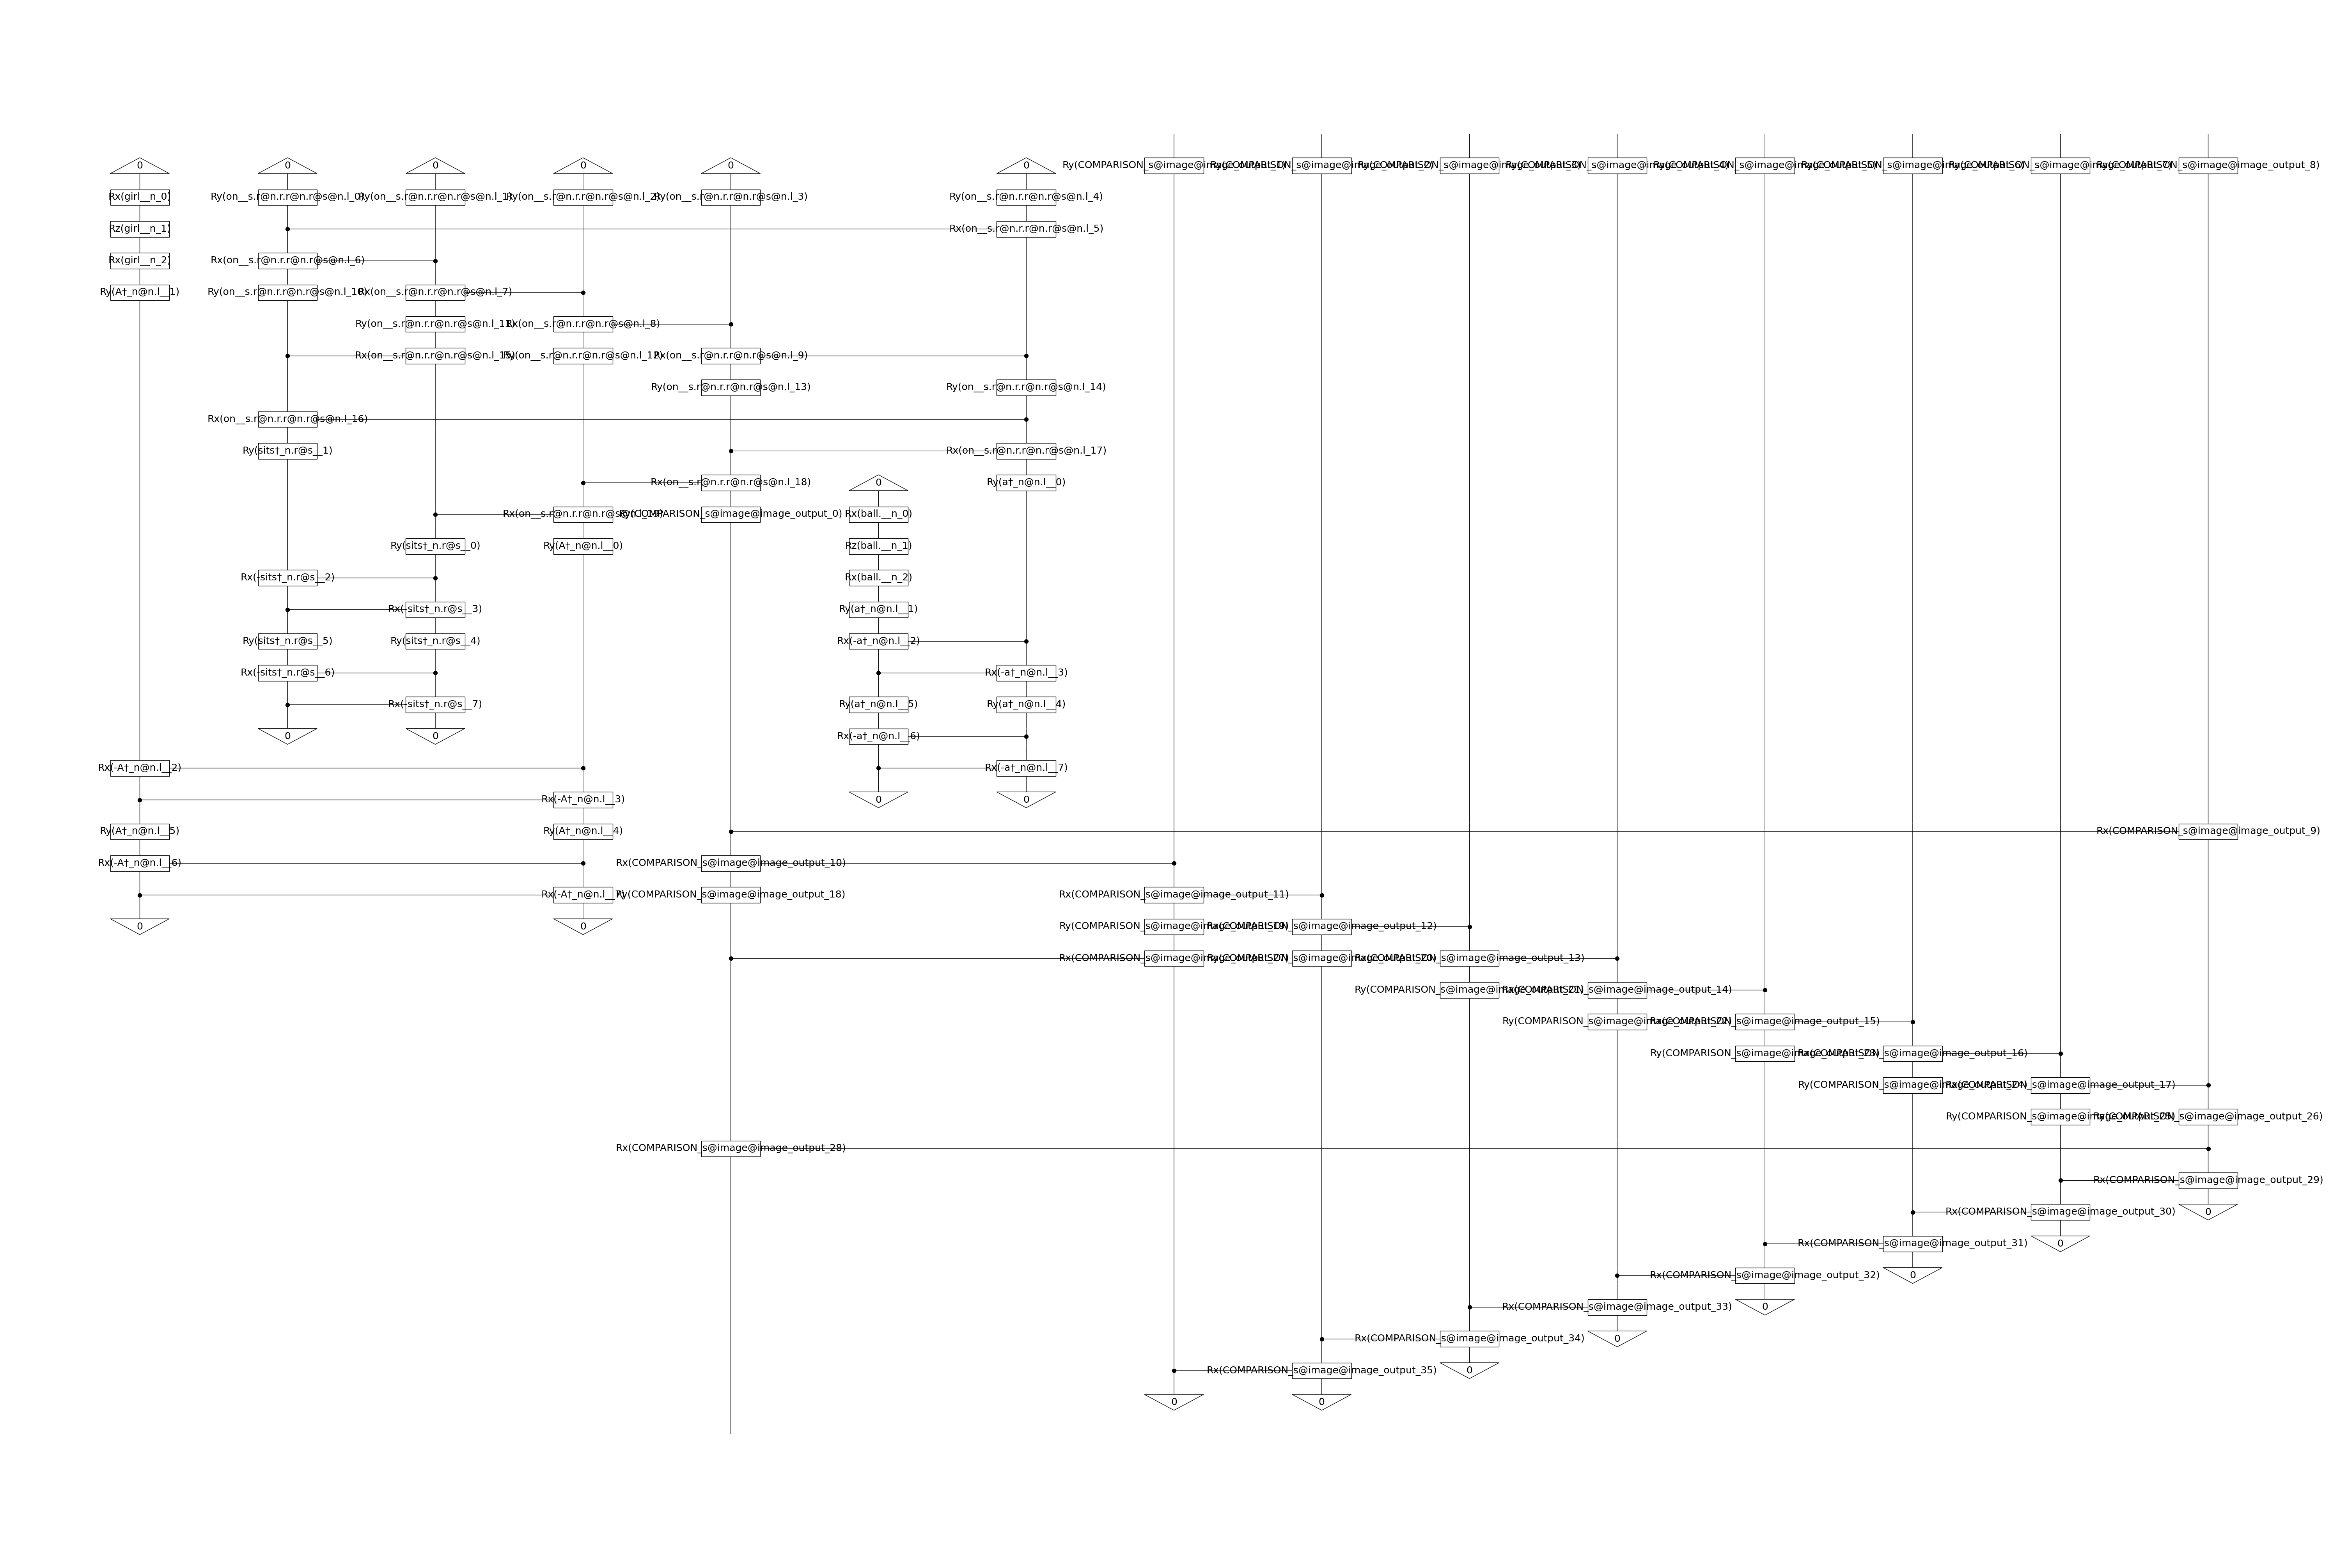

In [53]:
# Ansatz & Circuit
ansatz = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, image_type : 4, output_type : 1},  n_layers=1)

print("NOTE: ansatz that cause an error are not added to the list")
print(" this is due to a prepositional phrase found in the sentence")
conc_circuit = []
print("=======================")
for num in range(len(conc_diagrams)):
    try:
        temp = ansatz(conc_diagrams[num])
        conc_circuit.append(temp)
    except Exception as e:
        print(f"Error at index {num}: {e}")
print("=======================")

print(f"\n(*) {len(conc_circuit)} / {len(conc_diagrams)} / {len(df)} diagrams completed successfully!\n")

# temp_circuit = [ansatz(diagram) for diagram in conc_diagrams]
print(" ↓ template circuit : (sentence, image_type , image_type)")
conc_circuit[0].draw(figsize=(60, 40), fontsize=18, draw_type_labels = False )



#### Final Circuit 

  ↓ sample quantum circuit : (sentence, image data pos , image data neg)


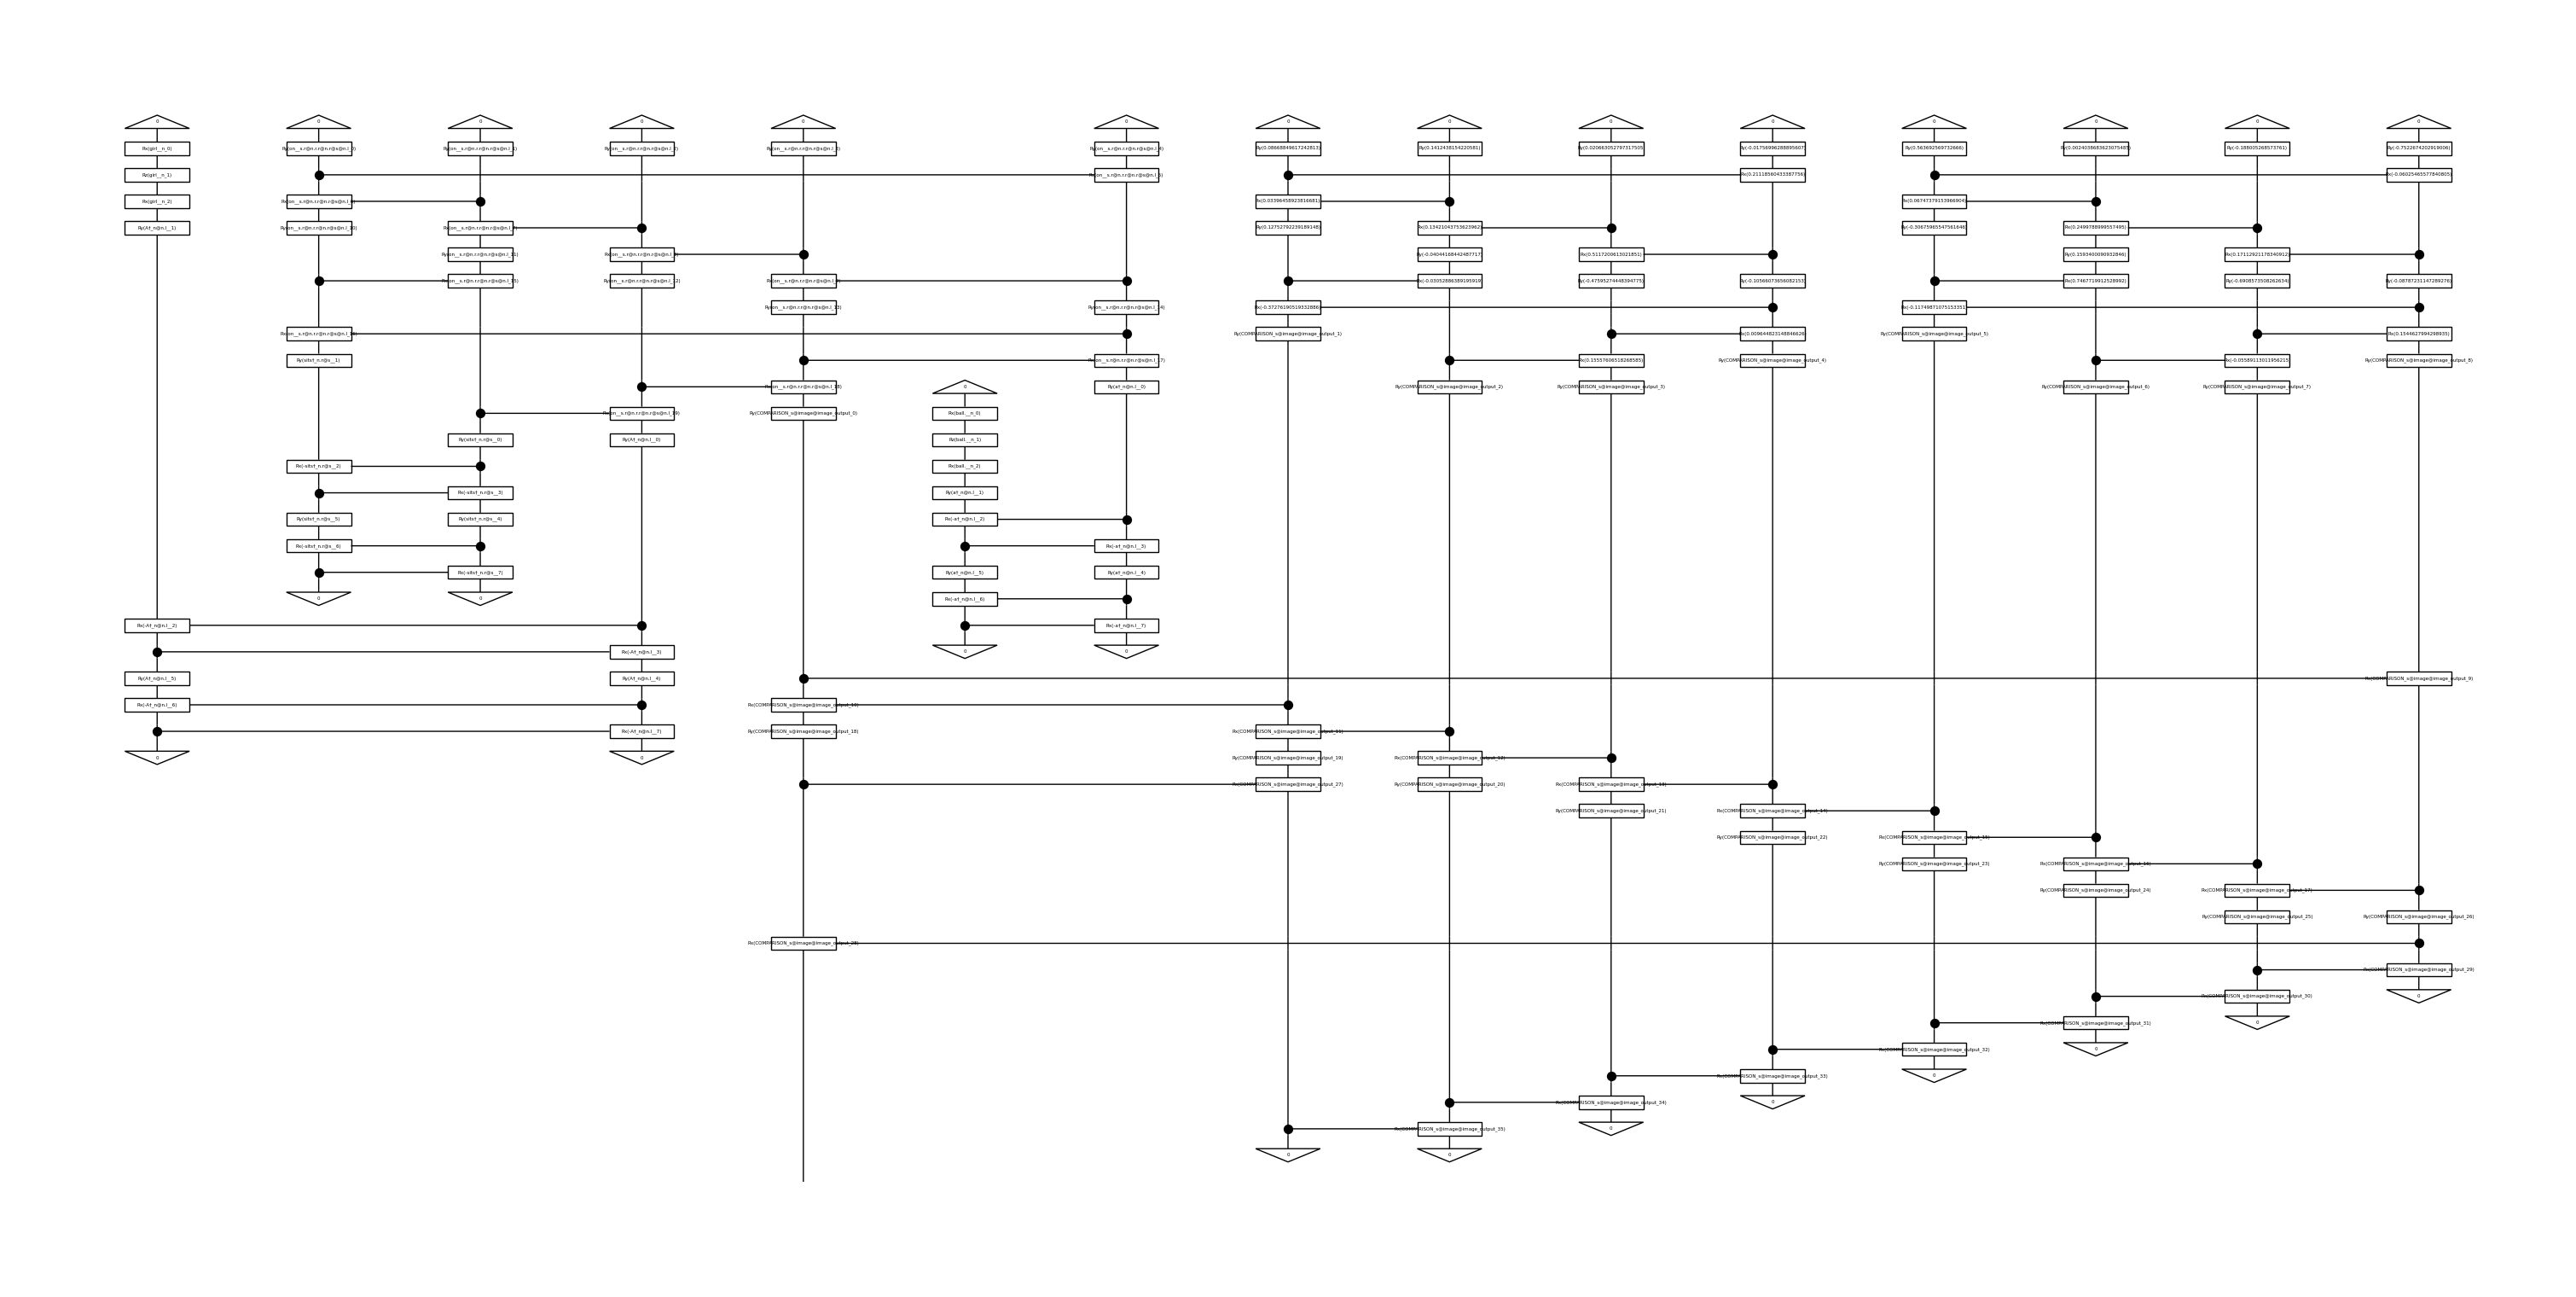

In [54]:
# final_circuit = image_1 @ image_2 >> temp_circuit

final_circuit = [(train_circuits_image1[index] @ train_circuits_image2[index] >> conc_circuit[index]) for index in range(len(conc_circuit))]

print("  ↓ sample quantum circuit : (sentence, image data pos , image data neg)")
final_circuit[0].draw(figsize=(30, 15), fontsize=4, draw_type_labels = False )
